# A minimal compartmental model for an epidemic

In this exercise we will build a small mathematical model for the spread of an epidemic and use it to demonstrate a number of techniques, including basic parallelization.

### Requirements

The following exercise requires a number of skills which are essential for efficiently performing basic data analysis. I recommend that users install an Anaconda environment with the following dependencies:

```
dependencies:
  - python=3.7
  - matplotlib
  - scipy
  - numpy
  - nb_conda_kernels
  - au-eoed::gnu-parallel
  - pip
```

There are instructions for building environments [available here](https://marcc-hpc.github.io/tutorials/shortcourse_python.html). Users are free to try the tutorial on *Blue Crab* or on their local machines, however by the end of this notebook we will use SLURM for some basic parallelization.

To build an environment with the dependencies above, add them to a text file called `reqs.yaml` and run:

```
conda create -p ./my_env --file reqs.yaml
``` 

followed by `conda activate ./my_env`. You are free to choose a different name. If you are using *Blue Crab*, you will have to load the anaconda module and activate the environment whenever you want to use it.

```
ml anaconda
conda activate ./path/to/my_env
```

We recommend using an informative name and installing software on our home or data locations (`~/` and `~/data`).

### Lesson objectives

1. Solve a simple ordinary differential equation (ODE) for a minimal epidemic model
2. Perform a parameter sweep to understand the model better
3. Create a stochastic simulation for the model
4. Visualize and save the results

### Code objectives

1. Understand Python imports
2. Conceptualize builtin data types
3. Use basic `numpy` data types
4. Write functions using arguments and keyword arguments
5. Use generators such as `enumerate` to build loops
6. Understand array "slicing" in `numpy`
7. Make histograms

## 1. The model

The susceptible-infected-recovered (SIR) model can be used to describe the spread of disease in a population.

$$
\begin{aligned}
\frac{dS}{dt} &= \mu N - \mu S - \beta \frac{S I}{N} \\
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I - \mu I \\
\frac{dR}{dt} &= \gamma I - \mu R \\
N &= S + I + R
\end{aligned}
$$

In this model, $S,I,R$ represent the proportion of susceptible, infected, and recovered components of a population. The $\mu$ parameter is the population growth rate for a mean lifetime of $\frac{1}{\mu}$. The transmission or contact rate is $\beta$ and represents the number of disease-transmitting contacts per unit time per infected host. The recovery parameter $\gamma$ is the number of recoveries per unit time, giving an expected duration of the disease of $\frac{1}{\gamma}$ which implicitly assumes a waiting time of $e^{-\gamma t}$. Because it includes population growth and the spread of a disease, the model captures both biological and behavioral components. 

For this exercise, we assume zero population growth ($\mu=0$) which reduces the model significantly.

$$
\begin{aligned}
N &= S + I + R \\
\frac{dS}{dt} &= - \beta \frac{S I}{N} \\
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I
\end{aligned}
$$

The model assumes a "well-mixed" population. The original formulation of this model is due to Kermack and McKendrick (1927). The following exercise is adapted from [a course by Chris Meyers](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/SIR/SIR.html).

This exercise will require the use of both `scipy` and [a magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) to render `matplotlib` images inside the notebook.

In [1]:
# import required libraries
import sys
import numpy as np
import scipy
import scipy.integrate

In [2]:
# imports for plotting
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt

Before continuing, we will review the basics of `numpy` data types. You can read more about this [in the manual](https://docs.scipy.org/doc/numpy/reference/).

In [3]:
# numpy basics:
a = [1,2,3]
a * 10
b = np.array([1,2,3])
b * 10
# what about `a * 10`?

array([10, 20, 30])

For this phase of the example, we will choose some starting parameters, namely an outbreak that starts with a single infected individual. Later we will sweep these parameters.

In [4]:
# initial settings
N = 100
I = 1
S = N - I
R = 0
beta = 0.2
gamma = 1./10

In [5]:
# a single timestep
y0 = np.array([S, I, R], dtype=float)/N

In this section we will define the ODE and then perform a single update step.

In [6]:
# choose a starting point
y = y0
# define the differential equations
s,i,r = y
dsdt = -beta * s * i
didt = beta * s * i - gamma *i
drdt = gamma * i
update = np.array([dsdt, didt, drdt])
y += update
print('update: %s'%update)
print('state: %s'%y)

update: [-0.00198  0.00098  0.001  ]
state: [0.98802 0.01098 0.001  ]


In [7]:
# a quick primer on arguments and keyword arguments
def function(a,*b):
    print('argument a: %s'%str(a))
    print('argument(s) *b: %s'%str(b))
function(1,2,3,4)

argument a: 1
argument(s) *b: (2, 3, 4)


Next we will formalize the ODE in a function that returns the update.

In [8]:
def dydt(y,t,beta,gamma):
    s,i,r = y
    dsdt = -beta * s * i
    didt = beta * s * i - gamma *i
    drdt = gamma * i
    update = np.array([dsdt, didt, drdt])
    return update

In [9]:
dydt(y0,0,beta=beta,gamma=gamma)

array([-0.00216969,  0.00107169,  0.001098  ])

Now that we have formulated the problem, we wil use `scipy` to solve it directly. You can read the [`odeint` documentation online](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html).

In [10]:
times = np.arange(100)
answer = scipy.integrate.odeint(dydt, y0, times, args=(beta, gamma))

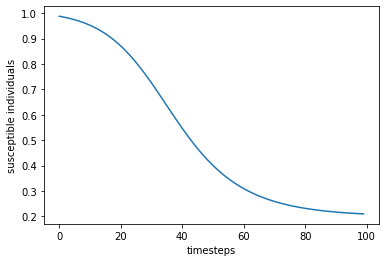

In [11]:
# make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times,answer[:,0],'-',label='susceptible')
ax.set_xlabel('timesteps')
ax.set_ylabel('susceptible individuals')
plt.show()

In [12]:
# tip: we recommend the use of `enumerate` for indexing
list(enumerate('abc'))

[(0, 'a'), (1, 'b'), (2, 'c')]

The plot above shows the decline of susceptible individuals as the infection spreads through the population. In the next section we will plot all three populations.

In [13]:
def review(times,*series,fn=None):
    """Summarize the results."""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    names=('susceptible','infected','recovered')
    for ii,i in enumerate(series):
        ax.plot(times,i,'-',label=names[ii])
    ax.legend()
    ax.set_xlabel('timesteps')
    ax.set_ylabel('susceptible individuals')
    if fn:
        plt.savefig('trajectory.png')
    plt.show()

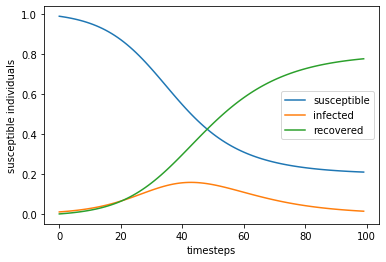

In [14]:
review(times,*answer.T)

An alternate parameter to describe our model is the *basic reproduction number*, $R_0 = \frac{\beta}{\gamma}$ which represents the transmission rate over the mean duration of the disease. If this parameter dips below 1, then we might expect the disease to die out on average. The following code will solve the ODE for different $R_0$ values. The results of this parameter sweep are plotted below.

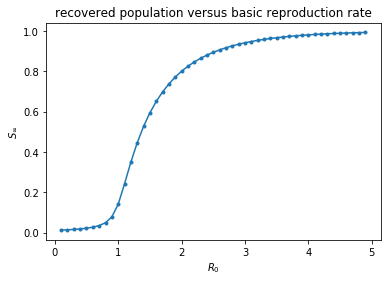

In [15]:
# choose a sufficiently long time
times = np.arange(1000)
r0_vals = np.arange(0.1,5,0.1)
sweep = np.zeros((len(r0_vals),2))
gamma = 10.0
for row,r0 in enumerate(r0_vals):
    beta = r0*gamma
    answer = scipy.integrate.odeint(dydt, y0, times, args=(beta, gamma))
    sweep[row] = (r0,answer[-1][-1])
# plot the sweep
plt.plot(sweep.T[0],sweep.T[1],'.-')
plt.xlabel('$R_0$')
plt.ylabel(r'$S_\infty$')
plt.title('recovered population versus basic reproduction rate')
plt.show()

In the next sections we will generate a stochastic dynamic system to more accurately model this problem and then parallelize it.

## 2. A Stochastic Model for the Epidemic

In this section we will use the Gillespie algorithm to simulate the infection in a more realistic population with discrete numbers of infected individuals who acquire the disease in explicit steps. We will continue to follow the [course by Chris Meyers](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/SIR/SIR.html). The precise details of our model are not essential for the exercise. The purpose is to develop a repeatable experiment which we can run in parallel. We will define the `StochasticSIR` class below to represent each experiment.

In [16]:
# initial settings
N = 100
I = 1
S = N - I
R = 0
beta = 0.2
gamma = 1./10

In [17]:
class StochasticSIR:

    def __init__(self,beta,gamma,S,I,R):
        self.S = S
        self.I = I
        self.R = R
        self.beta = beta
        self.gamma = gamma
        self.t = 0.
        self.N = S + I + R
        self.trajectory = np.array([[self.S, self.I, self.R]])
        self.times = None

    def step(self):
        transition = None
        # define rates
        didt = self.beta * self.S * self.I
        drdt = self.gamma * self.I
        total_rate = didt + drdt
        if total_rate == 0.:
            return transition, self.t
        # get a random number
        rand = np.random.random()
        # rates determine the event
        if rand < didt/drdt:
            self.S -= 1
            self.I += 1
            transition = 1
        else:
            self.I -= 1
            self.R += 1
            transition = 2
        # the event happens in the future
        dt = np.random.exponential(1./total_rate,1)[0]
        self.t += dt
        return transition, self.t

    def run(self, T=None, make_traj=True):
        """The Gillespie algorithm."""
        if T is None:
            T = sys.maxsize
        self.times = [0.]
        t0 = self.t
        transition = 1
        while self.t < t0 + T:
            transition, t = self.step()
            if not transition:
                return self.t
            if make_traj: self.trajectory = np.concatenate(
                (self.trajectory, [[self.S,self.I,self.R]]), axis=0)
            self.times.append(self.t)
        return self.tB

Using the class above, we can simulate the model using the following commands.

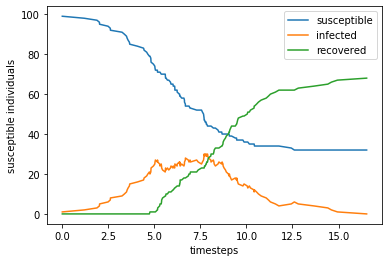

[32  0 68]


In [18]:
model = StochasticSIR(0.005,1./2,100-1,1,0)
model.run()
review(model.times,*model.trajectory.T)
print(model.trajectory[-1])

We can also repeat this experiment many times inside a `for` loop and then summarize the results. In the plot below, we are showing the distribution of the number of infected and therefore recovered individuals for 1000 different experiments. We find that less than 1% of the infections do not spread beyond patient zero. This is a useful readout from our model which depends on the model parameters.

In [34]:
# run many experiments
beta = 0.005
gamma = 1./2
N = 100
I = 1
S = N-I
n_expts = 1000
result = np.zeros((n_expts,))
for expt_num in range(len(result)):
    model = StochasticSIR(beta=beta,gamma=gamma,S=S,I=I,R=R)
    model.run()
    result[expt_num] = model.trajectory[-1][2]

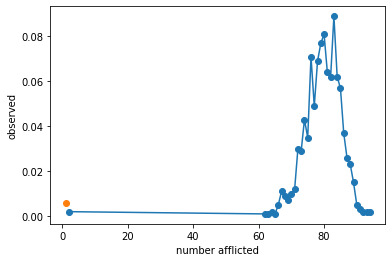

In [37]:
# summarize the experiments
counts,edges = np.histogram(result,bins=0.5+np.arange(0,N+1))
mids = (edges[1:]+edges[:-1])/2.
valid = np.all((counts>0,mids>1),axis=0)
plt.plot(mids[valid],counts[valid]/n_expts,'o-')
plt.plot(mids[0],counts[0]/n_expts,'o')
plt.xlabel('number afflicted')
plt.ylabel('observed')
plt.show()

Compute the mean susceptibility for infections that spread beyond one person.

In [50]:
# explain a single result in words
print('The average recovered number of hosts if the infection spread is: %.2f'%result[result>1].mean())
print(r'In %.2f%% of cases the infection did not spread'%(np.mean(result<=1)*100))

The average recovered number of hosts if the infection spread is: 79.50
In 0.60% of cases the infection did not spread


### Study the transmission rate

Now that we have constructed a numerical experiment which tells us the likelihood that an infection will spread to a large part of the population, we can use this code to study the relationship between the transmission rate and the probably of an epidemic. In the following function we "sweep" the $\beta$ parameter assuming a fixed value for the recovery time $\gamma$ and thereby study the effects of the basic reproduction number, $R_0$.

In [22]:
# roll the models above into a single function
def study_beta(
    beta = .005,
    gamma = 1./2,
    N = 100,
    I = 1,
    n_expts = 1000):
    """Run many experiments for a particular beta 
    to see how many infections spread."""
    S = N-I
    result = np.zeros((n_expts,))
    for expt_num in range(len(result)):
        model = StochasticSIR(beta=beta,gamma=gamma,S=S,I=I,R=R)
        model.run()
        result[expt_num] = model.trajectory[-1][2]
    return result

n_expts = 100
beta_sweep = np.arange(0.001,0.02,0.001)

results = np.zeros((len(beta_sweep),n_expts))
for snum,beta in enumerate(beta_sweep):
    print('%d '%snum,end='')
    results[snum] = study_beta(beta=beta,n_expts=n_expts)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

In [24]:
# review the values in our sweep
beta_sweep

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019])

In [25]:
# reformulate the results
summary_stats = []
for enum,beta in enumerate(beta_sweep):
    result = results[enum]
    counts,edges = np.histogram(result,bins=0.5+np.arange(0,N+1))
    mids = (edges[1:]+edges[:-1])/2.
    valid = np.all((mids>1,counts>1),axis=0)
    row = (beta,counts[valid].mean(),counts[0])
    summary_stats.append(row)
# our first list comprehension!
beta_vs_spread = np.array([(beta,spread) for beta,spread,safe in summary_stats])
beta_vs_safe = np.array([(beta,safe) for beta,spread,safe in summary_stats])

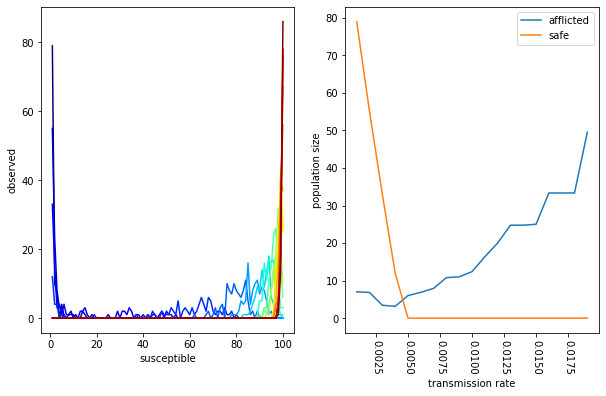

In [28]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(121)
color_vals = np.linspace(0,1,len(results))
for rnum,result in enumerate(results):
    counts,edges = np.histogram(result,bins=0.5+np.arange(0,N+1))
    mids = (edges[1:]+edges[:-1])/2.
    ax.plot(mids,counts,'-',color=mpl.cm.jet(color_vals[rnum]))
    ax.set_xlabel('susceptible')
    ax.set_ylabel('observed')
ax = plt.subplot(122)
ax.plot(*beta_vs_spread.T,label='afflicted')
ax.plot(*beta_vs_safe.T,label='safe')
plt.tick_params(axis='x', labelrotation=-90) 
ax.legend()
ax.set_xlabel('transmission rate')
ax.set_ylabel('population size')
plt.show()

The plots above capture two features of our sweep. On the left, we have a color-coded set of distributions. Each distribution includes the number of susceptible individuals after many experiments for a single transmission rate. The color represents the magnitude of the transmission rate (low rates are blue, high rates are red). On the right, we calculate the mean number of safe (uninfected) versus afflicted (those who get the disease) according to the transmission rate. We find that higher transmission rates increase the number people who get the disease. This characterizes an important feature of our model, namely, that there is a threshold transmission rate above which everybody is guaranteed to get the disease.

## 3. Package the Code

In order to perform a more extensive set of experiments, we will package the code from the example above by putting it into a single script. We can then run this script in parallel using SLURM or GNU parallel. In the following cell, we are using the magic `%%file` syntax to write the file.

In [75]:
%%file epidemic_expt.py

# import required libraries
import sys
import numpy as np
import scipy
import scipy.integrate

class StochasticSIR:

    def __init__(self,beta,gamma,S,I,R):
        self.S = S
        self.I = I
        self.R = R
        self.beta = beta
        self.gamma = gamma
        self.t = 0.
        self.N = S + I + R
        self.trajectory = np.array([[self.S, self.I, self.R]])
        self.times = None

    def step(self):
        transition = None
        # define rates
        didt = self.beta * self.S * self.I
        drdt = self.gamma * self.I
        total_rate = didt + drdt
        if total_rate == 0.:
            return transition, self.t
        # get a random number
        rand = np.random.random()
        # rates determine the event
        if rand < didt/drdt:
            self.S -= 1
            self.I += 1
            transition = 1
        else:
            self.I -= 1
            self.R += 1
            transition = 2
        # the event happens in the future
        dt = np.random.exponential(1./total_rate,1)[0]
        self.t += dt
        return transition, self.t

    def run(self, T=None, make_traj=True):
        """The Gillespie algorithm."""
        if T is None:
            T = sys.maxsize
        self.times = [0.]
        t0 = self.t
        transition = 1
        while self.t < t0 + T:
            transition, t = self.step()
            if not transition:
                return self.t
            if make_traj: self.trajectory = np.concatenate(
                (self.trajectory, [[self.S,self.I,self.R]]), axis=0)
            self.times.append(self.t)
        return self.tB
    
# roll the models above into a single function
def study_beta(
    beta = .005,
    gamma = 1./2,
    N = 100,
    I = 1,
    n_expts = 1000):
    """Run many experiments for a particular beta 
    to see how many infections spread."""
    S = N-I
    result = np.zeros((n_expts,))
    for expt_num in range(len(result)):
        model = StochasticSIR(beta=beta,gamma=gamma,S=S,I=I,R=R)
        model.run()
        result[expt_num] = model.trajectory[-1][2]
    return result

if __name__=='__main__':
    print(' '.join(sys.argv))
    # testing mode
    mode = 'test' if len(sys.argv)==2 else 'sweep'
    
    # ensure that we have an argument for the seed
    if len(sys.argv)<2:
        raise Exception('you must supply a seed')
    else: seed_val = int(sys.argv[1])

    # initial settings
    N = 1000
    I = 1
    S = N - I
    R = 0
    beta = 0.2
    gamma = 1./10
    
    # parameter sweep settings, ten total
    sweep_global = np.arange(0.001,0.02+0.001,0.002) 
    
    np.random.seed(seed_val)
    n_expts = 100
    if mode=='sweep':
        # if we send a second index it marks the beta parameter in the sweep
        index = int(sys.argv[2])
        beta = sweep_global[index]
    elif mode=='test':
        beta = 0.002
    result = study_beta(beta=beta,n_expts=n_expts)
    if mode=='test':
        print('result: %s'%str(result))
        print('average: %s'%str(result.mean()))
    elif mode=='sweep':
        # write the results to a file
        with open('result_%d.txt'%index,'w') as fp:
            fp.write("n_expts %d\nN %d\nI %d\nS %d\nbeta %.4f\ngamma %.4f\nresult %s\n"%(
                n_expts,N,I,S,beta,gamma,result))
            fp.write('average %s\n'%str(result.mean()))

Overwriting epidemic_expt.py


In the code above, I have forced the user to include an argument for the numerical "seed" for our random number generator. Use the magic BASH operator (`1`) to try this experiment a few times to see what the results are.

In [76]:
# run a single experiment
! time python epidemic_expt.py 1

epidemic_expt.py 1
result: [ 1. 20.  1.  1.  2.  2.  1.  6.  4.  1.  1.  1.  1. 16.  2. 12.  1.  2.
  1.  1.  2.  1.  4.  1.  1.  3. 12.  1.  2.  1.  2.  1.  1.  4.  5.  5.
  4.  1.  1.  1.  1.  1.  1.  1.  3.  4.  1.  1.  1.  4.  1.  2.  3.  1.
  2.  1.  1.  1.  1.  2.  1.  1.  1.  2.  2.  3.  2.  1.  1.  1.  1.  1.
  2.  1.  1.  1. 15.  3.  1.  1.  1.  3.  1.  1.  2.  1.  2.  5.  4.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  4.]
average: 2.39

real	0m0.582s
user	0m0.537s
sys	0m0.168s


We have access to an infinite but countable number of random seeds which must be unique for every set of experiments we wish to run. You must always be mindful of the the fact that your results will be [pseudo-random](https://www.sicara.ai/blog/2019-01-28-how-computer-generate-random-numbers).

## 3. Basic parallelism

Next we will use [GNU parallel](https://www.gnu.org/software/parallel/) to parallelize this calculation. We will discuss the following syntax in class, however you are welcome to read the manual (via `! parallel --help`). Try to use different numbers of processors with the `-j` flag to see how it affects the speed.

In [77]:
# perform the parameter sweep with GNU parallel
! time parallel -j 4 "python epidemic_expt.py" 1 ::: {0..9}

epidemic_expt.py 1 0
epidemic_expt.py 1 1
epidemic_expt.py 1 2
epidemic_expt.py 1 3
epidemic_expt.py 1 4
epidemic_expt.py 1 5
epidemic_expt.py 1 6
epidemic_expt.py 1 7
epidemic_expt.py 1 8
epidemic_expt.py 1 9

real	0m2.249s
user	0m6.789s
sys	0m1.606s


In [78]:
# check for the results files and view them with `! cat result_*`
! ls
# ! cat result_*

beta_susceptible.png  result_0.txt          result_5.txt
epidemic.ipynb        result_1.txt          result_6.txt
epidemic_expt.py      result_2.txt          result_7.txt
epidemic_expt_post.py result_3.txt          result_8.txt
epidemic_job.sh       result_4.txt          result_9.txt


Collect the results by reading the numbers from the last line of each results file.

In [79]:
import glob
fns = glob.glob('result_*')

In [80]:
# collect all of the data
collected = {}
for fn in fns:
    with open(fn) as fp:
        text = fp.read()
    lines = text.splitlines()
    # join and split the data
    lines_reduced = dict([(i.split()[0],' '.join(i.split()[1:])) for i in lines])
    # index the data by beta
    collected[lines_reduced['beta']] = lines_reduced

In [81]:
# reformulate the results
ts = [(float(j['beta']),float(j['average'])) for i,j in collected.items()]
ts = sorted(ts,key=lambda x:x[0])

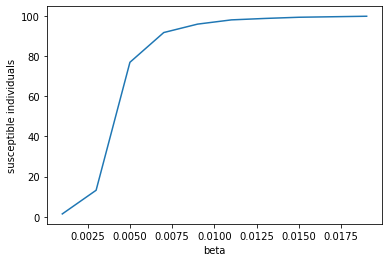

In [82]:
# make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(*zip(*ts),'-',label='susceptible')
ax.set_xlabel('beta')
ax.set_ylabel('susceptible individuals')
plt.show()

Now that we have run the calculation in parallel, we can write a script to do the post-processing.

In [83]:
%%file epidemic_expt_post.py

# imports for plotting
import matplotlib as mpl
# turn off the backend
mpl.use('Agg')
import matplotlib.pyplot as plt

import glob
fns = glob.glob('result_*')

# collect all of the data
collected = {}
for fn in fns:
    with open(fn) as fp:
        text = fp.read()
    lines = text.splitlines()
    # join and split the data
    lines_reduced = dict([(i.split()[0],' '.join(i.split()[1:])) for i in lines])
    # index the data by beta
    collected[lines_reduced['beta']] = lines_reduced

# reformulate the results
ts = [(float(j['beta']),float(j['average'])) for i,j in collected.items()]
ts = sorted(ts,key=lambda x:x[0])

# make a plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(*zip(*ts),'-',label='susceptible')
ax.set_xlabel('beta')
ax.set_ylabel('susceptible individuals')
plt.savefig('beta_susceptible.png')
plt.close()

Overwriting epidemic_expt_post.py


In [84]:
! python epidemic_expt_post.py

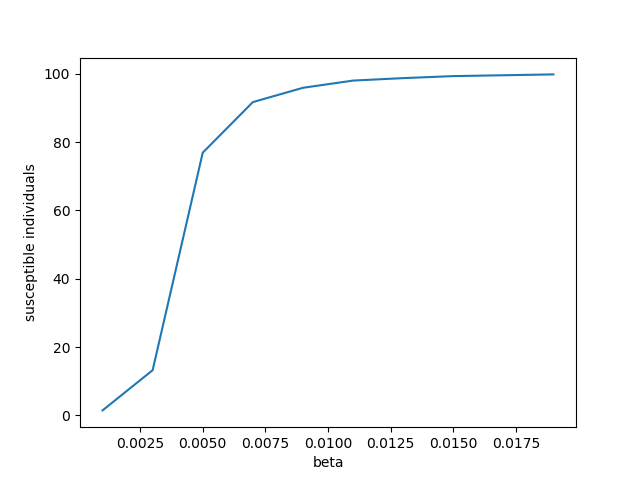

In [85]:
# check on the image inside the notebook
from IPython.display import Image
Image(filename='beta_susceptible.png') 

In [66]:
# clean up the files
! rm result_* beta_susceptible.png

The above example describes a typical workflow in which we parallelize a calculation and then "merge" the result using some kind of post-processing code.

## 4. SLURM Job Arrays

In this section we will use a SLURM job array. The job array should only be used when your calculation takes longer than a few minutes, since there is a small (time) penalty for starting each new job. Using GNU parallel works much like a standard `for` loop and does not have such a penalty, however it requires that you allocation all of the hardware at once. Submitting a job array to SLURM will allow jobs to run whenever the hardware for a single job is available.

In [67]:
%%file epidemic_job.sh
#!/bin/bash

#SBATCH -p express
#SBATCH -c 1
#SBATCH -t 10
#SBATCH --array=0-9

module load anaconda
conda env list
conda activate plotly
export SEED=1
python epidemic_expt.py $SEED $SLURM_ARRAY_TASK_ID

Overwriting epidemic_job.sh


The workflow on MARCC might look something like this:
    
```
ssh marcc
# choose a location for this experiment
cd carefully/choose/a/path/please
# clone the repository
git clone http://github.com/marcc-hpc/esc
# go into the notebooks folder
cd tutorial-repo/notebooks
# load an environment with some of the programs we need
# note that you can make your own too update it with:
# conda env update --file reqs.yaml -p ./path/to/env
ml anaconda
conda env list
# use a public environment or activate your own
conda activate plotly
# if your envionment lacks GNU parallel, load the module for it
ml parallel
# use the prepared script to run a parameter sweep
parallel -j 4 python epidemic_expt.py 1 ::: {0..9}
# post-processing generates the plot
python epidemic_expt_post.py
# clean up the files for the next test
rm result_*
# inspect the job file first
cat epidemic_job.sh
# submit the file
sbatch job.sh
# reload the environment to do the post-processing
ml anaconda
conda activate plotly
# make the plot
python epidemic_expt_post.py
```

The exercise above is typically performed during a tutorial session, but should serve as a rough outline for the process of building an environment, running a python code in parallel using SLURM, and processing the results. This notebook has outlined the use of both GNU parallel and SLURM to accomplish the same result. In subsequent lessons we will learn more advanced methods for parallelization. These efforts also depend on properly packaging both your code and the inputs and outputs for a particular set of experiments. We will discuss the best practices for these kinds of workflows in subsequent lessons.